## Question 01

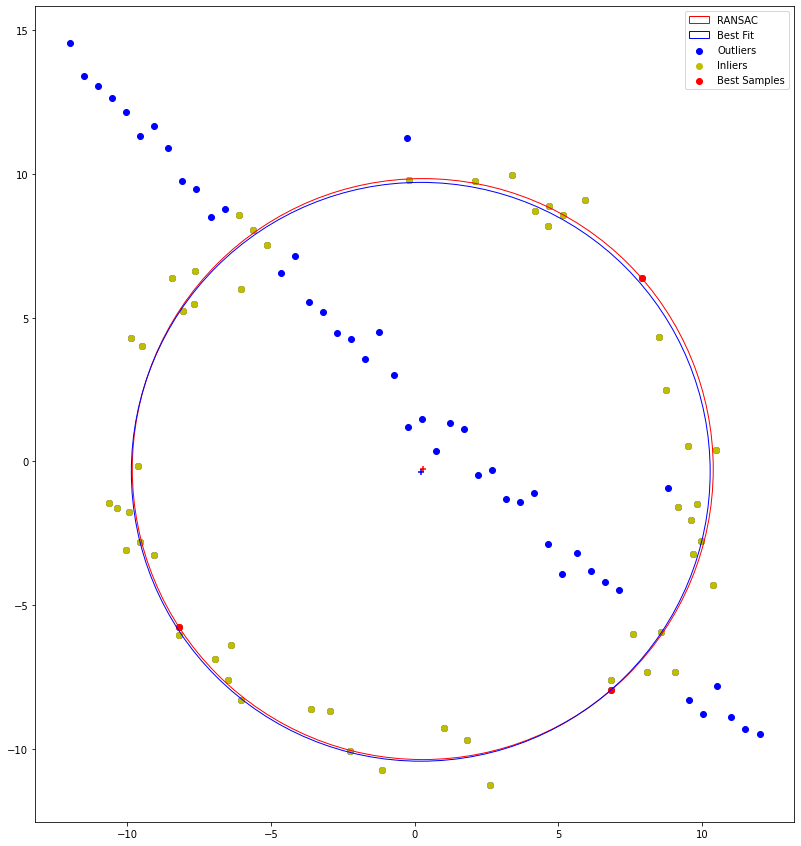

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
np.random.seed(4)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

threshold = 1.96*s
n = X.shape[0]
best_est = None
best_sample = None
S_in = []
p = 0.99
i = 0
e = 0.5
N = np.log(1 - p) / np.log(1 - e**(n/10))
while N > i:
    random_index = np.random.randint(n, size=3)
    pt1, pt2, pt3 = X[random_index]

    A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
    B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
    inv_A = np.linalg.pinv(A)

    a, b = np.dot(inv_A, B) / 2
    a, b = a[0], b[0]
    r = np.sqrt((a - pt1[0])**2 + (b - pt1[1])**2)

    S_tst = []
    for x, y in X:
        dis = np.sqrt((x - a)**2 + (y - b)**2)
        if (np.abs(dis - r) < threshold):
            S_tst.append([x,y])
    
    if (len(S_tst) > len(S_in)):
        best_est = (a, b, r)
        best_sample = random_index
        S_in = S_tst
    i+=1

a, b, r = best_est[0], best_est[1], best_est[2]
S_in = np.array(S_in)
P = np.concatenate((S_in, np.ones((S_in.shape[0], 1))), axis=1)
Q = S_in[:,[0]]**2 + S_in[:, [1]]**2
B = np.linalg.pinv(P.T @ P) @ P.T @ Q
a0, b0, c = B.flatten()
r0 = np.sqrt(a0**2 + b0**2 + c)

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X[:, 0], X[:, 1], c='blue', marker='o', label='Outliers')
ax.scatter(S_in[:, 0], S_in[:, 1], c='y', marker='o', label='Inliers')
ax.scatter(X[best_sample][:, 0], X[best_sample][:, 1], c='r', marker='o', label='Best Samples')
ax.scatter(a, b, c='r', marker='+')
ax.scatter(a0, b0, c='b', marker='+')
circle_best_sample = plt.Circle((a, b), radius=r, color='r', fc='y', fill=False, label='RANSAC')
circle_best_fit = plt.Circle((a0, b0), radius=r0, color='b', fc='y', fill=False, label='Best Fit')
plt.gca().add_patch(circle_best_sample)
plt.gca().add_patch(circle_best_fit)
ax.legend()
ax.axis('scaled')
plt.savefig('Report/images/ransac.png')
plt.show()

## Question 01

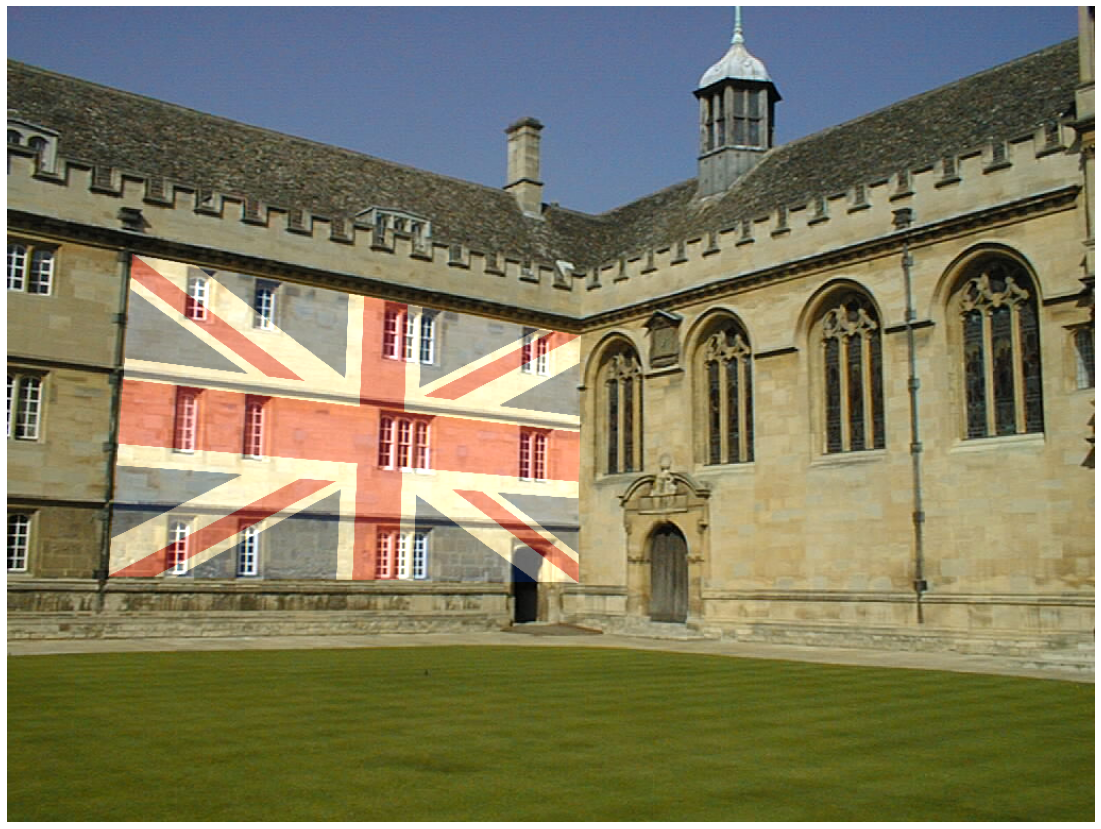

In [216]:
import cv2 as cv
Y = np.empty((0,2))
def click_event(event, x, y, flags, params):
    global Y
    if event == cv.EVENT_LBUTTONDOWN and len(Y) < 4:
        Y = np.vstack((Y, [x, y]))
        font = cv.FONT_HERSHEY_SIMPLEX
        cv.circle(img,(x,y), 5,(0,0,255),-1)
        cv.imshow('image', img)
        
img = cv.imread('002.jpg')
img_copy = img.copy()
cv.imshow('image', img)
cv.setMouseCallback('image', click_event)
cv.waitKey(0)
cv.destroyAllWindows()

uk_flag = cv.imread('uk_flag.png')
shape = uk_flag.shape
X = np.array([[0, 0], [shape[1]-1, 0], [0, shape[0]-1], [shape[1]-1, shape[0]-1]])
A = np.empty((8, 8))
for i in range(4):
    A[2*i] = [X[i][0], X[i][1], 1, 0, 0, 0, -Y[i][0]*X[i][0], -Y[i][0]*X[i][1]]
    A[2*i+1] = [0, 0, 0, X[i][0], X[i][1], 1, -Y[i][1]*X[i][0], -Y[i][1]*X[i][1]]
b = Y.reshape((8,1))

h = np.linalg.inv(A) @ b
H = np.vstack((h,[1]))
H = H.reshape((3, 3))

uk_transformed = cv.warpPerspective(uk_flag, H, (img.shape[1], img.shape[0]))
blend_img = cv.addWeighted(img_copy, 1, uk_transformed, 0.4, 0)

fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(cv.cvtColor(blend_img, cv.COLOR_BGR2RGB))
ax.axis('off')
plt.savefig('Report/images/uk1.png')
plt.show()

## Question 03

In [3]:
def find_hormograpy(src_pts, dst_pts):
    n = src_pts.shape[0]
    A = np.empty((2*n, 9))
    for i in range(n):
        A[2*i] = [src_pts[i][0], src_pts[i][1], 1, 0, 0, 0, -dst_pts[i][0]*src_pts[i][0], -dst_pts[i][0]*src_pts[i][1], -dst_pts[i][0]]
        A[2*i+1] = [0, 0, 0, src_pts[i][0], src_pts[i][1], 1, -dst_pts[i][1]*src_pts[i][0], -dst_pts[i][1]*src_pts[i][1], -dst_pts[i][1]]
    W, V = np.linalg.eig(A.T @ A)
    ev_corresponding_to_smalest_ev = V[:, np.argmin(W)]
    return ev_corresponding_to_smalest_ev.reshape((3, 3))

In [466]:
def ransac(src_pts, dst_pts):
    best_inliers = []
    best_H = None
    n = len(src_pts)
    for i in range(100):
        random_index = np.random.randint(n, size=4)
        random_src_pts = src_pts[random_index]
        random_dst_pts = dst_pts[random_index]
        H = find_hormograpy(random_src_pts, random_dst_pts)

        inliers = []
        for j in range(n):
            est = H @ np.hstack((src_pts[j], 1))
            est = (1/est[2])*est[:2]
            error = np.linalg.norm(est - dst_pts[j])

            if error < 10:
                inliers.append(j)
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H
        if (len(best_inliers) > n*0.5):
            break
    return best_inliers, H

In [223]:
def blend(src_img, dst_img):
    im = cv.cvtColor(src_img, cv.COLOR_BGR2GRAY)
    bw = cv.distanceTransform(im, cv.DIST_L1, cv.DIST_MASK_PRECISE)
    bw = cv.cvtColor(bw, cv.COLOR_GRAY2BGR)
    src_out = src_img * bw/bw.max()
    dst_out = dst_img * (bw.max() - bw)/bw.max()
    final = src_out + dst_out
    final = np.array(final, dtype=np.uint8)
    return final

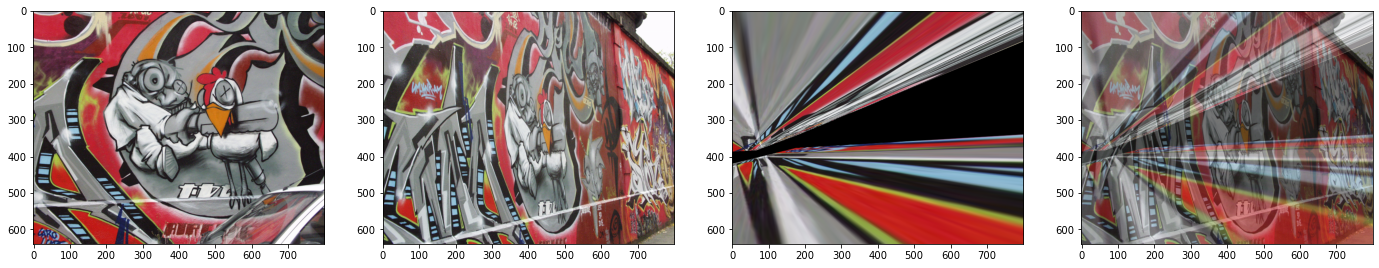

In [258]:
img1 = cv.imread('images/img1.ppm')
assert img1 is not None
img2 = cv.imread('images/img5.ppm')
assert img2 is not None

sift = cv.xfeatures2d.SIFT_create()
keypoint_1, descriptor_1 = sift.detectAndCompute(img1, None)
keypoint_2, descriptor_2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptor_1,descriptor_2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)
    
img3 = cv.drawMatches(img1,keypoint_1,img2,keypoint_2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

cv.imshow('image', img3)
cv.waitKey(0)
cv.destroyAllWindows()
src_pts = np.float32([ keypoint_1[m.queryIdx].pt for m in good ])
dst_pts = np.float32([ keypoint_2[m.trainIdx].pt for m in good ])
inl, H = ransac(src_pts, dst_pts)
sr = src_pts[inl]
ds = dst_pts[inl]
H = find_hormograpy(sr, ds)
img3 = cv.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
final = blend(img3, img2)
fig, ax= plt.subplots(1, 4, figsize=(24,10))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[2].imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
ax[3].imshow(cv.cvtColor(cv.addWeighted(img2,0.5,img3,0.5,0), cv.COLOR_BGR2RGB))

In [211]:
im = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)
ret,bw = cv.threshold(im,0,255,cv.THRESH_BINARY)
bw = cv.cvtColor(bw, cv.COLOR_GRAY2BGR)
out1 = img3 * (bw /255)
out2 = img2 *((255-bw)/255) 
oo = out1 + out2
oo = np.array(oo, dtype=np.uint8)
cv.imshow('image', oo)
cv.waitKey(0)
cv.destroyAllWindows()

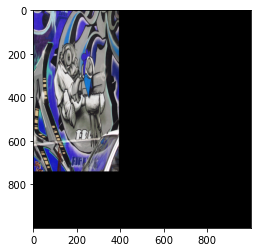

In [461]:

pre_H = np.array([ [1,   0,   0],
                [0 ,  1,  0],
                [ 0,0 ,  1]],dtype=np.float64)
pre_H = 1e-4 * np.random.randn(3,3) * pre_H
pre_img1 = cv.warpPerspective(img1, pre_H,(1000,1000))
plt.imshow(pre_img1)

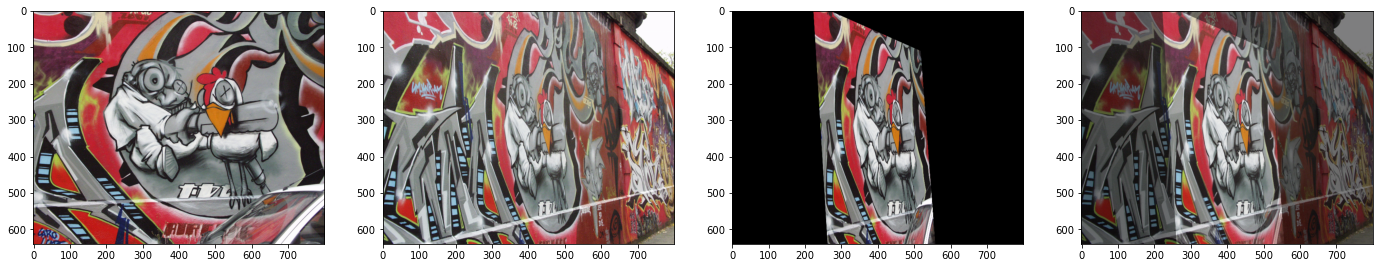

In [481]:
img1 = cv.imread('images/img1.ppm')
assert img1 is not None
img2 = cv.imread('images/img5.ppm')
assert img2 is not None
sift = cv.xfeatures2d.SIFT_create()
max_inliers = []
for i in range(30):
    pre_H = np.array([ [1,   0,   0],
                [0 ,  1,  0],
                [ 0,0 ,  1]],dtype=np.float64)
    pre_H = 1e-4 * np.random.randn(3,3) * pre_H
    pre_img1 = cv.warpPerspective(img1, pre_H,(1000,1000))
    keypoint_1, descriptor_1 = sift.detectAndCompute(pre_img1, None)
    keypoint_2, descriptor_2 = sift.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=100)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(descriptor_1,descriptor_2,k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    src_pts = np.float32([ keypoint_1[m.queryIdx].pt for m in good ])
    dst_pts = np.float32([ keypoint_2[m.trainIdx].pt for m in good ])
    if (len(src_pts)>4):
        inl, h = ransac(src_pts, dst_pts)
        if (len(inl) > len(max_inliers)):
            max_inliers = inl
            best_H = pre_H
            sr = src_pts[max_inliers]
            ds = dst_pts[max_inliers]

H = find_hormograpy(sr, ds)
H = H @ best_H
img3 = cv.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
final = blend(img3, img2)
fig, ax= plt.subplots(1, 4, figsize=(24,10))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[2].imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
ax[3].imshow(cv.cvtColor(cv.addWeighted(img2,0.5,img3,0.5,0), cv.COLOR_BGR2RGB))

In [482]:
H / H[2][2]

array([[ 6.14528782e-01,  5.57255243e-02,  2.21630043e+02],
       [ 2.15537133e-01,  1.14273294e+00, -2.10010009e+01],
       [ 4.75618699e-04, -6.03106572e-05,  1.00000000e+00]])